# Modify the Interim Biogeographic Regionalisation for Australia (IBRA) Version 7

These polygons define the analysis extents over which we summarise NDVI seasonal cycles.

Original vector file from here:
* regions: https://fed.dcceew.gov.au/datasets/a5a9a356105b4a728d0606194d8bdf38_0/explore
* subregions: https://fed.dcceew.gov.au/datasets/38e668537a2141be85b8418ac8b6f3ed_0/explore

IBRA is natural ecologies only, so we modify it by including cropping classes. The rainfed and irrigated cropping extents are taken from GFSAD ("lgrip30v001"), then we split these regions by biolclimatic region (rainfed) and by states (irrigated).  Lastly, urban regions are removed.

***
TO DO:
* Look for a better urban areas mask. What about CLUM?

In [1]:
%matplotlib inline
import os
import sys
import warnings
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import seaborn as sb
import xarray as xr
import numpy as np
from matplotlib.patches import Patch

import contextily as ctx
import matplotlib.pyplot as plt
import distinctipy
from matplotlib.colors import LinearSegmentedColormap

from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_vectorize

## Open data

In [2]:
region_type = 'regions' #regions subregions

#open IBRA
if region_type=='subregions':
    gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/ibra7_subregions.geojson')
    gdf = gdf.cx[110:160,-10:-45] #get rid of antarctic, christmas islands
    var='SUB_NAME_7'

if region_type=='regions':
    gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/ibra7_regions.geojson')
    gdf = gdf.cx[110:160,-10:-45] #get rid of antarctic, christmas islands
    gdf = gdf[gdf['FEAT_ID'].isin(['GA_100K_Mainland','GA_100K_Islands'])]
    var='REG_NAME_7'

gdf = gdf[[var, 'geometry']]
print(len(gdf))

#open bioclim regions
# bioclim = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/bioclimatic_regions.geojson')

85


In [3]:
# gdf.explore(column='SUB_NAME_7',
#            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#            attr = 'Esri',
#            name = 'Esri Satellite',
#            )

## Intial Plot

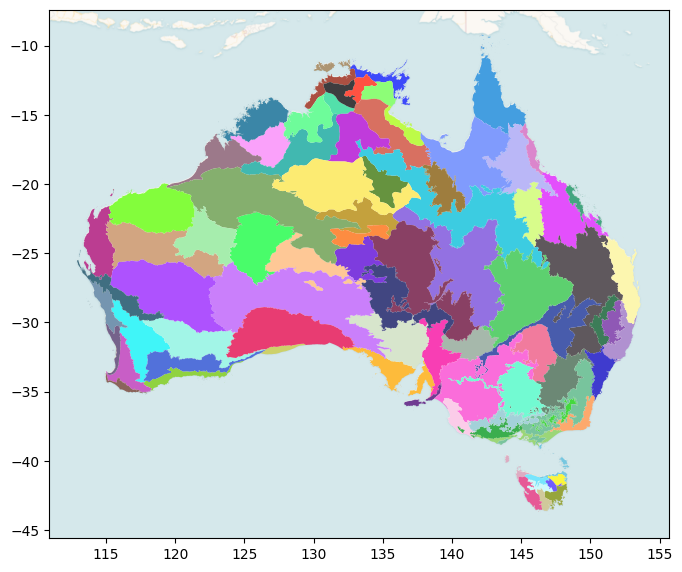

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = distinctipy.get_colors(len(gdf), pastel_factor=0.3)
a = gdf.plot(column=var, ax=ax, legend=False, cmap=LinearSegmentedColormap.from_list(
        'ecoregions', colors, N=len(gdf)))
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

## Add cropping layers

Based on the GFSAD rainfed and irrigated cropping layers, derived from Landsat. See the `Cropland_GFSAD.ipynb` notebook.

Also dividing cropping regions into the state territories

* 0=nodata
* 1=noncrop
* 2-irrigated
* 3-rainfed

In [5]:
#create a cropping geometery
path = '/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc'
crop = assign_crs(xr.open_dataset(path), crs='epsg:4326')['croplands']

#individual classes
irrigated = (crop==2)
rainfed = (crop==3)

#vectorise
irrigated = xr_vectorize(irrigated, dtype='int16')
irrigated = irrigated[irrigated['attribute']==1.0]
irrigated['zone'] = 1
irrigated = irrigated.dissolve(by='zone', aggfunc='sum')
irrigated = irrigated.drop('attribute', axis=1)
irrigated[var] = 'irrigated crop'

rainfed = xr_vectorize(rainfed, dtype='int16')
rainfed = rainfed[rainfed['attribute']==1.0]
rainfed['zone'] = 1
rainfed = rainfed.dissolve(by='zone', aggfunc='sum')
rainfed[var] = 'rainfed crop'

### Intersect cropping regions with ecoregions 

In [6]:
# rainfed_crop_ecoregions.explore(column=var,
#            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#            attr = 'Esri',
#            name = 'Esri Satellite',
#            )

In [7]:
rainfed_crop_ecoregions = gdf.overlay(rainfed, how='union')
rainfed_crop_ecoregions[var] = rainfed_crop_ecoregions[var+'_1'] +" "+ rainfed_crop_ecoregions[var+'_2']
rainfed_crop_ecoregions = rainfed_crop_ecoregions[~rainfed_crop_ecoregions[var].isna()]
rainfed_crop_ecoregions = rainfed_crop_ecoregions[[var, 'geometry']]

irrigated_crop_ecoregions = gdf.overlay(irrigated, how='union')
irrigated_crop_ecoregions[var] = irrigated_crop_ecoregions[var+'_1'] +" "+ irrigated_crop_ecoregions[var+'_2']
irrigated_crop_ecoregions = irrigated_crop_ecoregions[~irrigated_crop_ecoregions[var].isna()]
irrigated_crop_ecoregions = irrigated_crop_ecoregions[[var, 'geometry']]

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/geopandas/geodataframe.py:2467: UserWarning: `keep_geom_type=True` in overlay resulted in 457 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [8]:
gdf = gpd.overlay(gdf, rainfed_crop_ecoregions, how='symmetric_difference')
gdf[var] = gdf[var+'_1'].astype(str) + gdf[var+'_2'].astype(str)
gdf[var] = gdf[var].str.strip('nan')
gdf = gdf.drop([var+'_1',var+'_2'], axis=1)

gdf = gpd.overlay(gdf, irrigated_crop_ecoregions, how='symmetric_difference')
gdf[var] = gdf[var+'_1'].astype(str) + gdf[var+'_2'].astype(str)
gdf[var] = gdf[var].str.strip('nan')
gdf = gdf.drop([var+'_1',var+'_2'], axis=1)

#now merge back together
gdf = pd.concat([gdf,rainfed_crop_ecoregions,irrigated_crop_ecoregions])
gdf = gdf.reset_index(drop=True) #tidy

## Remove urban regions

In [9]:
urban = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/urban_mask_1km.nc')
urban = xr_vectorize(urban, dtype='int16')
urban = urban[urban['attribute']==1.0]
urban['zone'] = 1
urban = urban.dissolve(by='zone', aggfunc='sum')
urban = urban.drop('attribute', axis=1)
gdf = gpd.overlay(gdf, urban, how='symmetric_difference')
gdf = gdf.dropna(axis=0, how='any').reset_index(drop=True)

/jobfs/119221104.gadi-pbs/ipykernel_283494/901572515.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 1073 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gdf = gpd.overlay(gdf, urban, how='symmetric_difference')


## Filter very small polygons

In [10]:
gdf = gdf.to_crs('EPSG:3577')
gdf["area_ha"] = gdf.geometry.area/10000
gdf = gdf[gdf["area_ha"]>2500] #area equal to one 5*5 km pixel
gdf = gdf.to_crs('EPSG:4326')
gdf = gdf.drop('area_ha', axis=1)
print(len(gdf))

156


## Plot

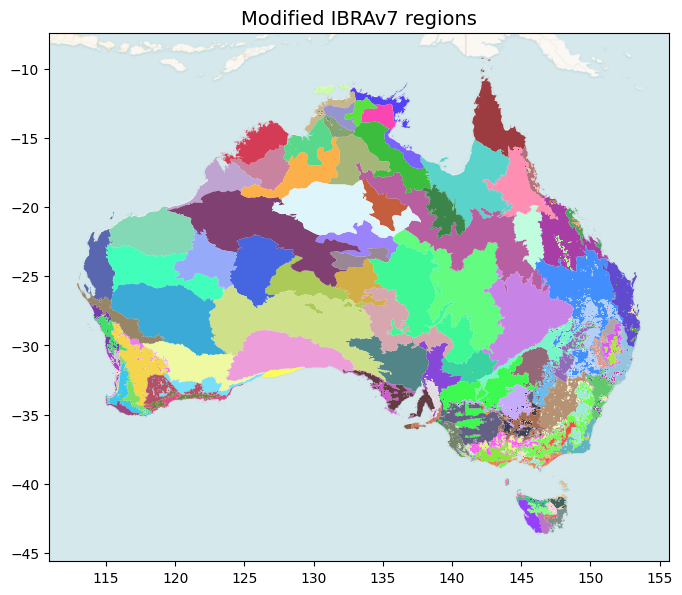

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = distinctipy.get_colors(len(gdf), pastel_factor=0.3)
a = gdf.plot(column=var, ax=ax, legend=False, cmap=LinearSegmentedColormap.from_list(
        'ecoregions', colors, N=len(gdf)))
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
plt.title('Modified IBRAv7 '+region_type, fontsize=14);
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/IBRAv7_'+region_type+'.png', bbox_inches='tight', dpi=300)

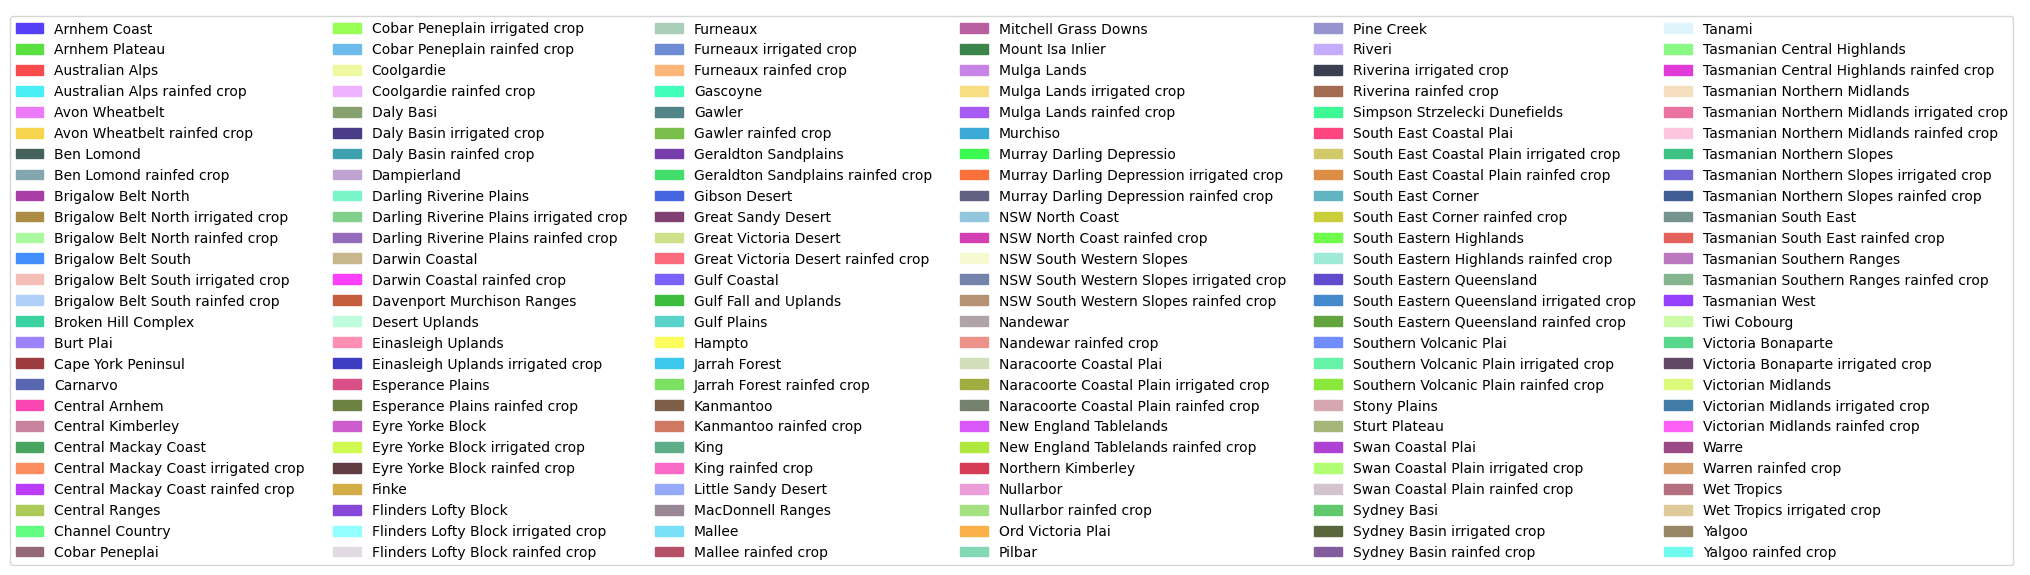

In [12]:
names=list(gdf[var])
names.sort()
legend_elements = [Patch(facecolor=c, edgecolor=c,label=n) for c,n in zip(colors,names)]
# Create the figure
fig, ax = plt.subplots()
ax.axis(False)
ax.legend(handles=legend_elements, loc="best", fontsize=10, ncol=6);
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/IBRAv7_'+region_type+'_legend.png', bbox_inches='tight', dpi=300)

## Save file

In [13]:
gdf.to_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_'+region_type+'_modified.geojson')

In [14]:
len(gdf)

156

## Interactive plot

In [15]:
# gdf.explore(column=var,
#            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#            attr = 'Esri',
#            name = 'Esri Satellite',
#            )

### Split crops by bioclim region

Additionally split the mediterranean region by east/west

In [16]:
# states = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/state_boundaries.geojson')
# states = states.drop(['STE_CODE21', 'CHG_FLAG21', 'CHG_LBL21', 'AUS_CODE21',
#        'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21'], axis=1)

# wa = states[states['STE_NAME21'] == 'Western Australia']
# wa = wa.drop(['STE_NAME21'], axis=1)

# sa_vic_nsw = states[states['STE_NAME21'].isin(['South Australia', 'Victoria', 'New South Wales'])]
# sa_vic_nsw = sa_vic_nsw.drop('STE_NAME21', axis=1)
# sa_vic_nsw['zone'] = 1
# sa_vic_nsw = sa_vic_nsw.dissolve(by='zone', aggfunc='sum')

# nsw = states[states['STE_NAME21'] == 'New South Wales']
# nsw = nsw.drop(['STE_NAME21'], axis=1)

# sa = states[states['STE_NAME21'] == 'South Australia']
# sa = sa.drop(['STE_NAME21'], axis=1)

# vic = states[states['STE_NAME21'] == 'Victoria']
# vic = vic.drop(['STE_NAME21'], axis=1)

# qld = states[states['STE_NAME21'] == 'Queensland']
# qld = qld.drop(['STE_NAME21'], axis=1)

# tas = states[states['STE_NAME21'] == 'Tasmania']
# tas = tas.drop(['STE_NAME21'], axis=1)


In [17]:
# # isolate biolcim regions
# med = bioclim[bioclim['region_name'] == 'Mediterranean'].drop(['region_name','bioclimatic_regions'],axis=1)
# cool_temperate = bioclim[bioclim['region_name'] == 'Cool Temperate'].drop(['region_name','bioclimatic_regions'],axis=1)
# warm_temperate = bioclim[bioclim['region_name'] == 'Warm Temperate'].drop(['region_name','bioclimatic_regions'],axis=1)
# savanna = bioclim[bioclim['region_name'] == 'Savanna'].drop(['region_name','bioclimatic_regions'],axis=1)
# tropics = bioclim[bioclim['region_name'] == 'Tropics'].drop(['region_name','bioclimatic_regions'],axis=1)

# # find the intersection of rainfed crops and the climates (split mediterranean into WA, east)
# # (also split cool temp into Tassie and mainland)
# warm_temp_crop = gpd.overlay(warm_temperate, rainfed, how='intersection')
# cool_temp_crop = gpd.overlay(cool_temperate, rainfed, how='intersection')
# cool_temp_crop_tas = gpd.overlay(cool_temp_crop, tas, how='intersection')
# cool_temp_crop_se = gpd.overlay(cool_temp_crop, sa_vic_nsw, how='intersection')
# savanna_crop = gpd.overlay(savanna, rainfed, how='intersection')
# # tropics_crop = gpd.overlay(tropics, rainfed, how='intersection')
# med_crop = gpd.overlay(med, rainfed, how='intersection')
# med_crop_wa = gpd.overlay(med_crop, wa, how='intersection')
# med_crop_east = gpd.overlay(med_crop, sa_vic_nsw, how='intersection')

# # find the intersection of irrigated crops and the states
# wa_irrigated = gpd.overlay(wa, irrigated, how='intersection')
# sa_irrigated = gpd.overlay(sa, irrigated, how='intersection')
# vic_irrigated = gpd.overlay(vic, irrigated, how='intersection')
# nsw_irrigated = gpd.overlay(nsw, irrigated, how='intersection')
# qld_irrigated = gpd.overlay(qld, irrigated, how='intersection')
# # nt_irrigated = gpd.overlay(nt, irrigated, how='intersection')

# #remove areas in ecoregions where rainfed and irrigated crops are
# gdf = gpd.overlay(gdf, warm_temp_crop, how='symmetric_difference')
# gdf = gpd.overlay(gdf, cool_temp_crop_tas, how='symmetric_difference')
# gdf = gpd.overlay(gdf, cool_temp_crop_se, how='symmetric_difference')
# gdf = gpd.overlay(gdf, savanna_crop, how='symmetric_difference')
# gdf = gpd.overlay(gdf, med_crop_wa, how='symmetric_difference')
# gdf = gpd.overlay(gdf, med_crop_east, how='symmetric_difference')
# gdf = gpd.overlay(gdf, wa_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, sa_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, vic_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, nsw_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, qld_irrigated, how='symmetric_difference')
# # gdf = gpd.overlay(gdf, tropics_crop, how='symmetric_difference')
# # gdf = gpd.overlay(gdf, nt_irrigated, how='symmetric_difference')

# #add attrs
# warm_temp_crop[var] = 'Rainfed crop warm temp.'
# cool_temp_crop_tas[var] = 'Rainfed crop cool temp. TAS'
# cool_temp_crop_se[var] = 'Rainfed crop cool temp. mainland'
# savanna_crop[var] = 'Rainfed crop savanna'
# # tropics_crop['ECO_NAME'] = 'Rainfed cropping tropics'
# med_crop_wa[var] = 'Rainfed crop mediterranean West'
# med_crop_east[var] = 'Rainfed crop mediterranean East'
# wa_irrigated[var] = 'Irrigated crop WA'
# sa_irrigated[var] = 'Irrigated crop SA'
# vic_irrigated[var] = 'Irrigated crop VIC'
# nsw_irrigated[var] = 'Irrigated crop NSW'
# qld_irrigated[var] = 'Irrigated crop QLD'
# # nt_irrigated['ECO_NAME'] = 'Irrigated cropping NT'

In [18]:
# gdf = pd.concat([gdf, warm_temp_crop, cool_temp_crop_se, cool_temp_crop_tas, savanna_crop, med_crop_wa,
#                 med_crop_east, wa_irrigated, sa_irrigated, vic_irrigated, nsw_irrigated,
#                 qld_irrigated,#nt_irrigated tropics_crop,
#                 ])

# #tidy
# gdf = gdf.dropna(axis=0, how='any').reset_index(drop=True)
# print(len(gdf))